<a href="https://colab.research.google.com/github/quanzz123/GradioTutorial/blob/main/Imageretriveval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install chromadb
!pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 79.4 MB/s eta 0:00:00
 

In [7]:


import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
import chromadb

ROOT = '/content/drive/MyDrive/data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))
def read_image_from_path(path, size):
    im = Image.open(path).convert('RGB').resize(size)
    return np.array(im)

def folder_to_images(folder, size):
    list_dir = [folder + '/' + name for name in os.listdir(folder)]
    images_np = np.zeros(shape=(len(list_dir), *size, 3))
    images_path = []
    for i, path in enumerate(list_dir):
        images_np[i] = read_image_from_path(path, size)
        images_path.append(path)
    images_path = np.array(images_path)
    return images_np, images_path

embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=image)
    return np.array(embedding)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
#Truy vấn ảnh nâng cao với đô đo L2
def plot_results(query_path, ls_path_score, reverse=False, top_k=5):
    """
    Plot the query image and the top matching images.

    Parameters:
    query_path (str): Đường dẫn đến query image
    ls_path_score (list): Danh sách đường dẫn và điểm
    reverse (bool): Đảo ngược điểm hoặc không
    top_k (int): Số lượng ảnh top cần hiển thị

    Returns:
    None
    """
    # Sort the list of image paths and scores in ascending order (for similarity scores)
    ls_path_score.sort(key=lambda x: x[1], reverse=reverse)

    # Load the query image
    query_img = Image.open(query_path)

    # Create a figure and axes
    fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 10))

    # Display the query image
    axes[0].imshow(query_img)
    axes[0].set_title("Query Image")
    axes[0].axis('off')

    # Display the top matching images
    for i, (img_path, score) in enumerate(ls_path_score[:top_k]):
        img = Image.open(img_path)
        axes[i + 1].imshow(img)
        img_name = os.path.basename(img_path)
        axes[i + 1].set_title(f"Top {i + 1}\nScore: {score:.2f}\n{img_name}")  # Display rank
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()


def mean_square_difference(query, data):
    axis_batch_size = tuple(range(1,len(data.shape)))
    return np.mean((data - query)**2, axis=axis_batch_size)
def mean_square_difference(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    return np.mean((data - query)**2, axis=axis_batch_size)

def cosine_similarity(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    query_norm = np.sqrt(np.sum(query**2))
    data_norm = np.sqrt(np.sum(data**2, axis=axis_batch_size))
    return np.sum(data * query, axis=axis_batch_size) / (query_norm * data_norm + np.finfo(float).eps)

def correlation_coefficient(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    query_mean = query - np.mean(query)
    data_mean = data - np.mean(data, axis=axis_batch_size, keepdims=True)
    query_norm = np.sqrt(np.sum(query_mean**2))
    data_norm = np.sqrt(np.sum(data_mean**2, axis=axis_batch_size))
    return np.sum(data_mean * query_mean, axis=axis_batch_size) / (query_norm * data_norm + np.finfo(float).eps)

def get_l2_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size) # mang numpy nhieu anh,paths

             # Check if images_np is empty
            if images_np.shape[0] == 0:
                print(f"Warning: Folder '{path}' is empty or contains no valid images.")
                continue  # Skip this folder if it's empty

            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
                rates = mean_square_difference(query_embedding, np.stack(embedding_list))
                ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

def get_cosine_similarity_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size) # mang numpy nhieu anh,paths
              # Check if images_np is empty
            if images_np.shape[0] == 0:
                print(f"Warning: Folder '{path}' is empty or contains no valid images.")
                continue  # Skip this folder if it's empty
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = cosine_similarity(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

def get_correlation_coefficient_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size) # mang numpy nhieu anh, paths
            # Check if images_np is empty
            if images_np.shape[0] == 0:
                print(f"Warning: Folder '{path}' is empty or contains no valid images.")
                continue  # Skip this folder if it's empty
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = correlation_coefficient(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score


root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Apple/142822489_b9da55627b_b.jpg"
size = (448, 448)





Độ đo L2


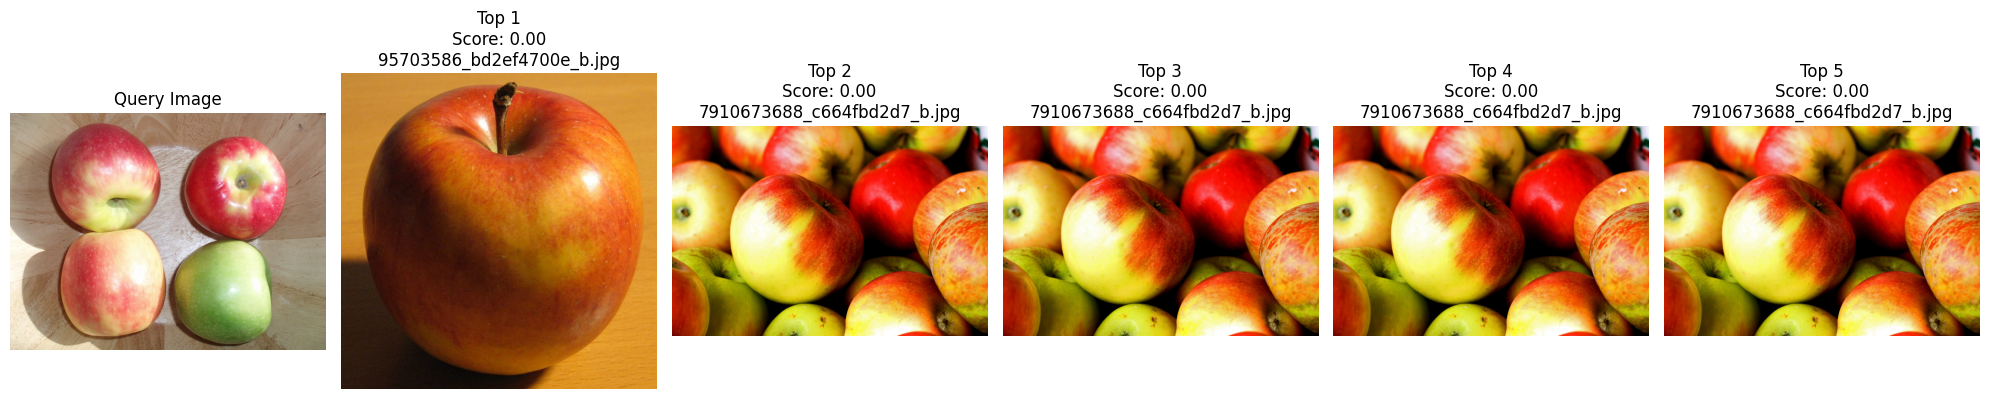

In [ ]:
#hiển thị
print("Độ đo L2")
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False, top_k=5)

In [ ]:
print("Top 5 anh voi  Correlation Coefficient")

query, ls_path_score = get_correlation_coefficient_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False, top_k=5)

Top 5 anh voi  Correlation Coefficient


KeyboardInterrupt: 

top 5 anh voi do do cosin


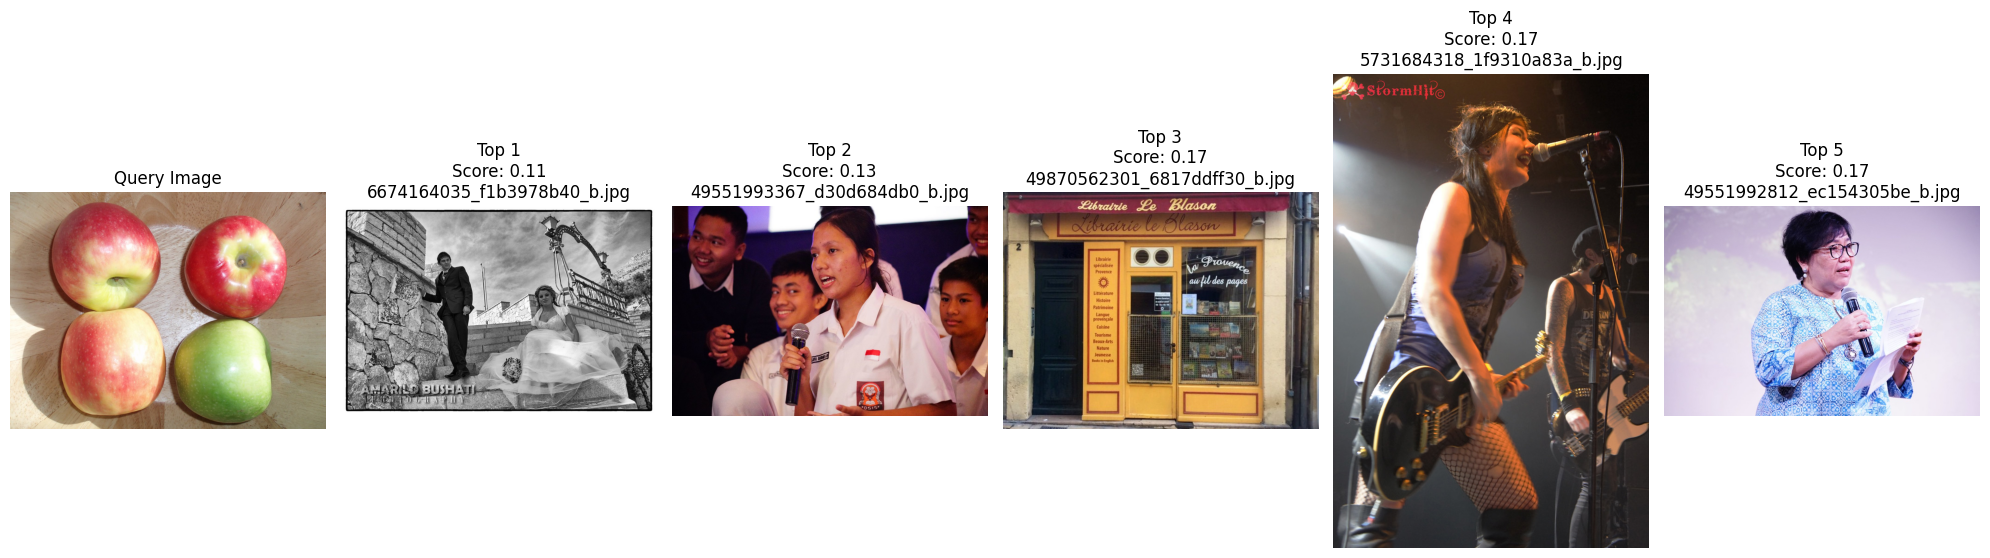

In [ ]:
print("top 5 anh voi do do cosin")
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False, top_k=5)

In [9]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + "/" + label
        filenames = os.listdir(label_path)
        for filename in filenames: # Corrected indentation
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

data_path = f'{ROOT}/train'
files_path = get_files_path(path=data_path)

In [10]:
from tqdm import tqdm # Make sure you import tqdm
import numpy as np # Import numpy

def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    metadatas = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image = Image.open(filepath)
        # Convert the PIL Image to a NumPy array
        image_np = np.array(image)
        embedding = get_single_image_embedding(image=image_np)
        embeddings.append(embedding)
        metadatas.append({"image_path": filepath})  # Store image path as metadata

    collection.add(
        embeddings=embeddings,
        ids=ids,
        metadatas=metadatas  # Add metadatas here
    )

In [12]:
!pip install chromadb

import chromadb
from chromadb.config import Settings

# Check if a Chroma client already exists
try:
    # Try to access the existing client
    chroma_client
    print("Reusing existing Chroma client.")
except NameError:
    # If it doesn't exist, create a new one
    print("Creating a new Chroma client.")
    chroma_client = chromadb.Client(Settings(chroma_db_impl="duckdb+parquet", persist_directory="db"))

# Now you can use chroma_client to create/access collections
# Use "hnsw:space" as the key in the metadata dictionary
l2_collection = chroma_client.get_or_create_collection(name="l2_collection",
metadata={"hnsw:space": "l2"}) # Changed from chromadb.config.Settings.HNSW_SPACE to "hnsw:space"
add_embedding(l2_collection, files_path) # Add to l2_collection

Creating a new Chroma client.


ValueError: [91mYou are using a deprecated configuration of Chroma.

[94mIf you do not have data you wish to migrate, you only need to change how you construct
your Chroma client. Please see the "New Clients" section of https://docs.trychroma.com/deployment/migration.
________________________________________________________________________________________________

If you do have data you wish to migrate, we have a migration tool you can use in order to
migrate your data to the new Chroma architecture.
Please `pip install chroma-migrate` and run `chroma-migrate` to migrate your data and then
change how you construct your Chroma client.

See https://docs.trychroma.com/deployment/migration for more information or join our discord at https://discord.gg/8g5FESbj for help![0m

In [12]:
# Create a Chroma Client
chroma_client = chromadb.Client()
# Now you can use chroma_client to create/access collections
# Use "hnsw:space" as the key in the metadata dictionary
l2_collection = chroma_client.get_or_create_collection(name="l2_collection",
metadata={"hnsw:space": "l2"}) # Changed from chromadb.config.Settings.HNSW_SPACE to "hnsw:space"
add_embedding(l2_collection, files_path) # Add to l2_collection

1155it [05:50,  3.29it/s]


In [13]:
def search(image_path, collection, n_results):
    query_image = Image.open(image_path).convert('RGB') # ensure RGB format
    query_image = np.array(query_image)  # Convert PIL Image to NumPy array
    query_embedding = get_single_image_embedding(query_image)
    results = collection.query(
    query_embeddings=[query_embedding],
                                n_results=n_results # how many results to return
    )
    return results

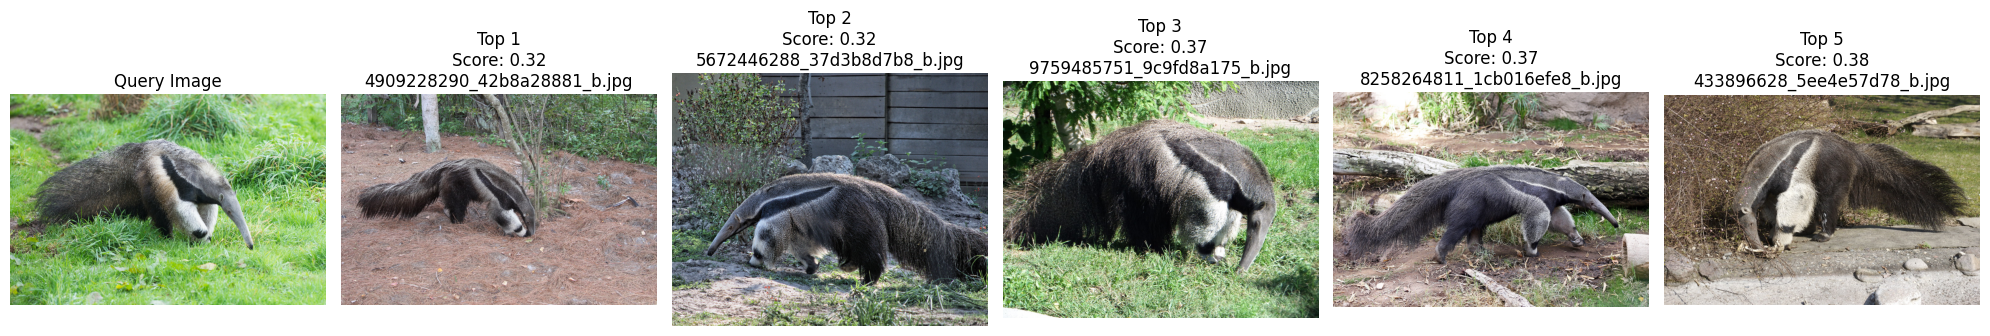

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def plot_results(image_path, files_path, results, reverse=False, top_k=5):
    """
    Plot the query image and the top matching images based on similarity.

    Parameters:
    image_path (str): Path to the query image.
    files_path (list): List of all file paths in the database.
    results (dict): Search results from ChromaDB, containing 'ids' and 'distances'.
    reverse (bool): Whether to reverse the sorting of the images based on similarity score.
    top_k (int): Number of top images to display.

    Returns:
    None
    """
    # Get the top k image IDs and distances (assuming results contain 'ids' and 'distances')
    ids = results['ids'][0]  # Assuming single query, adjust if it's batch query
    distances = results['distances'][0]

    # Create a list of (image_path, score) tuples
    ls_path_score = []
    for id, distance in zip(ids[:top_k], distances[:top_k]):
        # Find the corresponding file path using the ID
        # Assuming ids are in the format 'id_{index}'
        id_filepath = int(id.split('_')[1])
        img_path = files_path[id_filepath]
        ls_path_score.append((img_path, distance))

    # Sort the list of image paths and scores based on the distance
    # If reverse=True, we show the most similar images first
    ls_path_score.sort(key=lambda x: x[1], reverse=reverse)

    # Load the query image
    query_img = Image.open(image_path)

    # Create a figure and axes for the plots
    fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 10))

    # Display the query image on the first axis
    axes[0].imshow(query_img)
    axes[0].set_title("Query Image")
    axes[0].axis('off')  # Hide axes

    # Display the top-k matching images
    for i, (img_path, score) in enumerate(ls_path_score):
        img = Image.open(img_path)
        axes[i + 1].imshow(img)
        img_name = os.path.basename(img_path)
        axes[i + 1].set_title(f"Top {i + 1}\nScore: {score:.2f}\n{img_name}")
        axes[i + 1].axis('off')  # Hide axes

    # Make sure the layout doesn't overlap
    plt.tight_layout()
    plt.show()

# Example of calling the function
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[2]
l2_results = search(image_path=test_path, collection=l2_collection, n_results=5)

# Assuming files_path and l2_results are correctly passed
# Change: Use the original 'files_path' which contains all image paths
plot_results(image_path=test_path, files_path=files_path, results=l2_results)
# instead of test_files_path



Nhập đường dẫn của hình ảnh: /content/drive/MyDrive/data/test/tiger/14389915480_124382e917_b.jpg


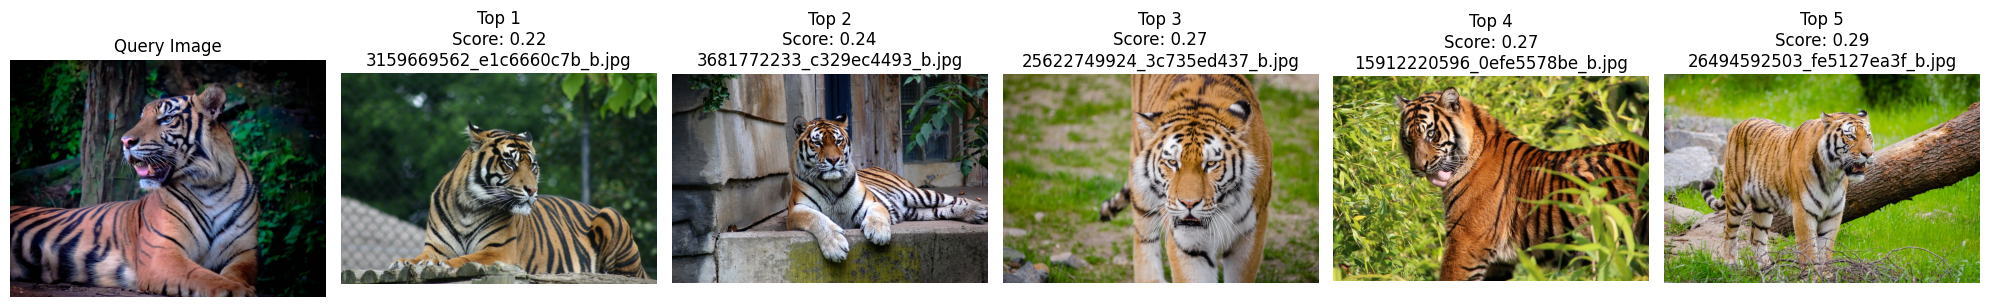

In [15]:
# Example of calling the function
# Get input from the user
test_path = input("Nhập đường dẫn của hình ảnh: ")

# Validate the input path
while not os.path.exists(test_path):
    print("Đường dẫn không hợp lệ. Vui lòng nhập lại.")
    test_path = input("Nhập đường dẫn của hình ảnh: ")

l2_results = search(image_path=test_path, collection=l2_collection, n_results=5)

plot_results(image_path=test_path, files_path=files_path, results=l2_results)

In [1]:
!pip install gradio

In [16]:
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image
import os
import io

# ... (Your existing code for search and plot_results functions) ...

def classify_image(image):
  """Classifies the input image and returns similar images."""
  # Save the uploaded image temporarily
  image.save("temp_image.jpg")

  # Perform the search
  l2_results = search(image_path="temp_image.jpg", collection=l2_collection, n_results=5)

  # Plot the results to an in-memory buffer
  buffer = io.BytesIO()
  plot_results(image_path="temp_image.jpg", files_path=files_path, results=l2_results)
  plt.savefig(buffer, format='png')
  buffer.seek(0)
  plot_image = Image.open(buffer)

  # Remove the temporary image file
  os.remove("temp_image.jpg")

  # Return the plotted image
  return plot_image

# Define the Gradio interface
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),  # Accept PIL Image as input
    outputs=gr.Image(type="pil"),  # Output a PIL Image
    title="Image Similarity Search",
    description="Upload an image to find 5 similar images."
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://416d21f64090e37040.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
def classify_image(image_path):
  """Classifies the input image and returns similar images."""

  # Perform the search
  l2_results = search(image_path=image_path, collection=l2_collection, n_results=5)

  # Plot the results to an in-memory buffer
  buffer = io.BytesIO()
  plot_results(image_path=image_path, files_path=files_path, results=l2_results)
  plt.savefig(buffer, format='png')
  buffer.seek(0)
  plot_image = Image.open(buffer)

  # Return the plotted image
  return plot_image

In [ ]:
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Textbox(lines=1, placeholder="Nhập đường dẫn của hình ảnh"),  # Accept image path as input
    outputs=gr.Image(type="pil"),  # Output a PIL Image
    title="Image Similarity Search",
    description="Nhập đường dẫn của hình ảnh để tìm 5 hình ảnh tương tự."
)

iface.launch()

In [17]:
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image
import os
import io

# ... (Your existing code for search and plot_results functions) ...

def classify_image(image_path):
  """Classifies the input image and returns similar images."""

  # Perform the search
  l2_results = search(image_path=image_path, collection=l2_collection, n_results=5)

  # Plot the results to an in-memory buffer
  buffer = io.BytesIO()
  plot_results(image_path=image_path, files_path=files_path, results=l2_results)
  plt.savefig(buffer, format='png')
  buffer.seek(0)
  plot_image = Image.open(buffer)

  # Return the plotted image
  return plot_image

iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Textbox(lines=1, placeholder="Nhập đường dẫn của hình ảnh"),
    outputs=gr.Image(type="pil"),
    title="Image Similarity Search",
    description="Nhập đường dẫn của hình ảnh để tìm 5 hình ảnh tương tự."
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c7b710ba7b258512dd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
